In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import json

In [3]:
def moving_average(data, window_size=15):
    X_smooth = np.zeros(data.shape)
    for i,channel in enumerate(data):
        X_smooth[i] = np.convolve(channel, np.ones(window_size)/window_size, mode='same')
    return torch.from_numpy(X_smooth).to(torch.float32)
def warp_time(data, label, max_scale=1.5):
    data = data.numpy()

    L = data.shape[1]
    scale = np.random.uniform(1, max_scale)
    new_L = int(L * scale)
    orig_t = np.linspace(0, 1, L)
    new_t = np.linspace(0, 1, new_L)

    warped = np.zeros((data.shape[0], new_L))
    for i, channel in enumerate(data):
        warped[i] = np.interp(new_t, orig_t, channel)
    
    # label = torch.from_numpy(np.interp(new_t, orig_t, label)).to(torch.float32)
    # label = label * scale

    # randomly crop to original length
    if new_L > L:
        start_idx = np.random.randint(0, new_L - L)
        warped = warped[:, start_idx:start_idx + L]
        # label = label[start_idx:start_idx + L]
        # label = label - (start_idx / L)

    return torch.from_numpy(warped).to(torch.float32), label

def scale(data, low=0.6, high=1.4):
    return data*np.random.uniform(low, high)

def segment_y(y, t=40):
    end_rep_markers = torch.where(torch.diff(y) < 0)[0]
    y = torch.zeros_like(y)
    starts = (end_rep_markers - t).clamp(0)
    ends = (end_rep_markers + t).clamp(0, y.shape[0])
    for start,end in zip(starts, ends):
        y[start: end] = 1
    return y
class IMUDataset(Dataset):
    def __init__(self, df, winsize, stride, full_winsize, n_LSTM_windows, LSTM_stride, transform=None, aug=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.full_winsize = full_winsize
        self.n_LSTM_windows = n_LSTM_windows
        self.LSTM_stride = LSTM_stride
        self.len = (self.X.shape[1] - full_winsize) // stride + 1
        self.aug = aug
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        if i >= self.len:
            raise IndexError
        start = i * self.stride
        end = start + self.full_winsize

        X = self.X[:, start:end]
        y = self.y[start:end]

        X = moving_average(X)
        if self.aug:
            X,y = warp_time(X,y)
            X = scale(X)
        
        # window by LSTM stride
        X = X.unfold(1, self.winsize, self.LSTM_stride).permute(1,0,2)
        y = y.unfold(0, self.winsize, self.LSTM_stride)

        # FOR REGRESSION: y = y.mean() (single value)
        # y = y.mean()

        # FOR BINARY: 1 if y is last rep (< 1.5), 0 if not (single value)
        # y = torch.Tensor([1.0 if y.mean() < 1.5 else 0.0])
        y = (y.mean(dim=1) < 1.5).float().unsqueeze(1)

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        # y = segment_y(y)

        # FOR SEGMENTATION REGRESSION: y = time when y changes (single value)
        # diff = torch.diff(y)
        # y = torch.diff(y).argmin().unsqueeze(0) / self.winsize if diff.min() < 0 else torch.Tensor([-1])
        
        return X, y

In [4]:
HZ = 100
in_channels = 6
df = pd.read_csv('../data/data-strom.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

df[['acc_x', 'acc_y', 'acc_z']] = (df[['acc_x', 'acc_y', 'acc_z']] / 2.0).clip(-1, 1)           # normalize accelerometer data from [-2g, 2g] to [-1, 1]
df[['gyr_x', 'gyr_y', 'gyr_z']] = (df[['gyr_x', 'gyr_y', 'gyr_z']] / 250.0).clip(-1, 1)         # normalize gyroscope data from [-250dps, 250dps] to [-1, 1]

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 256
stride = 2

n_LSTM_windows = 8
LSTM_stride = 64
print(winsize, stride)

full_winsize = LSTM_stride * (n_LSTM_windows-1) + winsize

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
# norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

# def transform(x):
    # return (x - norm[0]) / norm[1]
transform = None

train_dataset = ConcatDataset([IMUDataset(
    df[df['session_id'] == session_id], 
    winsize, stride,
    full_winsize, n_LSTM_windows, LSTM_stride,
    transform, aug=True
) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(
    df[df['session_id'] == session_id], 
    winsize, stride, 
    full_winsize, n_LSTM_windows, LSTM_stride,
    transform, aug=False
) for session_id in val_ids])

len(train_dataset), len(val_dataset)

72
256 2


(79986, 22985)

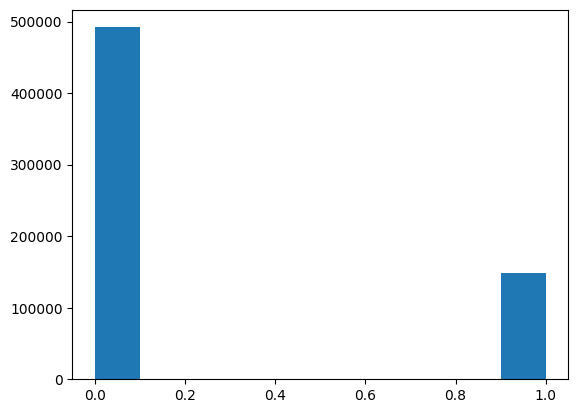

In [5]:
# windows = []
window_labels = []
for X, y in train_dataset:
    # windows.append(X.T.numpy())
    window_labels.append(y)
window_labels = np.concatenate(window_labels)
plt.hist(window_labels);

Text(0.5, 0.98, '[0. 0. 0. 0. 0. 1. 1. 1.]')

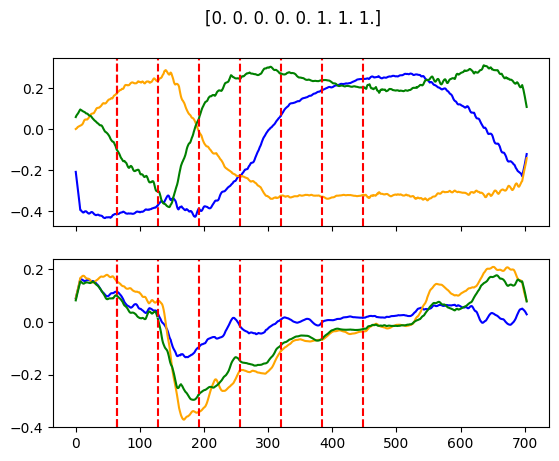

In [6]:
# X,y = train_dataset[0]
X,y = val_dataset[6760]

fig, axes = plt.subplots(2,1, sharex=True)

axes[0].plot(X[0, 0, :LSTM_stride], color='blue')
axes[0].plot(X[0, 1, :LSTM_stride], color='orange')
axes[0].plot(X[0, 2, :LSTM_stride], color='green')
axes[1].plot(X[0, 3, :LSTM_stride], color='blue')
axes[1].plot(X[0, 4, :LSTM_stride], color='orange')
axes[1].plot(X[0, 5, :LSTM_stride], color='green')
axes[0].axvline(LSTM_stride, color='red', linestyle='--')
axes[1].axvline(LSTM_stride, color='red', linestyle='--')

for i in range(1, n_LSTM_windows):
    upper = LSTM_stride if i < n_LSTM_windows - 1 else None
    range_upper = (i+1)*LSTM_stride if upper is not None else i*LSTM_stride + winsize
    axes[0].plot(np.arange(i*LSTM_stride, range_upper), X[i, 0, :upper], color='blue')
    axes[0].plot(np.arange(i*LSTM_stride, range_upper), X[i, 1, :upper], color='orange')
    axes[0].plot(np.arange(i*LSTM_stride, range_upper), X[i, 2, :upper], color='green')
    axes[1].plot(np.arange(i*LSTM_stride, range_upper), X[i, 3, :upper], color='blue')
    axes[1].plot(np.arange(i*LSTM_stride, range_upper), X[i, 4, :upper], color='orange')
    axes[1].plot(np.arange(i*LSTM_stride, range_upper), X[i, 5, :upper], color='green')
    axes[0].axvline(i*LSTM_stride, color='red', linestyle='--')
    axes[1].axvline(i*LSTM_stride, color='red', linestyle='--')

plt.suptitle(y[:,0].numpy())

In [144]:
class ResBlock(nn.Module):
    # One layer of convolutional block with batchnorm, relu and dropout
    def __init__(
            self, in_channels, out_channels,
            kernel_size=3, stride=1, dropout=0.0,
        ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, padding=kernel_size // 2,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.skip = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride
        ) if in_channels != out_channels or stride > 1 else nn.Identity()
    def forward(self, x):
        return self.block(x) + self.skip(x)
    
class DepthBlock(nn.Module):
    # "depth" number of ConvBlocks with downsample on the first block
    def __init__(
            self, depth, in_channels, out_channels,
            kernel_size=3, downsample_stride=2, 
            dropout=0.0
    ):
        super().__init__()
        self.blocks = nn.Sequential(*[
            ResBlock(
                in_channels=in_channels if i == 0 else out_channels, 
                out_channels=out_channels,
                kernel_size=kernel_size, 
                stride=downsample_stride if i == 0 else 1,
                dropout=dropout
            )
            for i in range(depth)
        ])
    def forward(self, x):
        return self.blocks(x)
 
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.width = config['width']
        self.depth = config['depth']
        self.stem_out_c = config['stem_out_c']
        self.stem_kernel = config['stem_kernel']
        self.dropout = config['dropout']

        if len(self.width) != len(self.depth):
            raise ValueError('Width and depth must have the same length')
        self.conv_out_channels = self.stem_out_c if len(self.width) == 0 else self.width[-1]

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, self.stem_out_c, kernel_size=self.stem_kernel, padding=self.stem_kernel // 2),
            nn.BatchNorm1d(self.stem_out_c),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            *[DepthBlock(
                depth=self.depth[i],
                in_channels=self.stem_out_c if i == 0 else self.width[i-1], 
                out_channels=self.width[i],
                dropout=self.dropout, 
            ) for i in range(len(self.width))]
        )
    def forward(self, x):
        return self.encoder(x)

class ConvNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.encoder = Encoder(config)
        self.ap = nn.AdaptiveAvgPool1d(1)
        # self.fc = nn.Linear(512, winsize // 2)
        self.fc = nn.Linear(self.encoder.conv_out_channels, winsize)
    def forward(self, x):
        emb = self.encoder(x)
        # x = self.conv(x)
        x = self.ap(emb).squeeze(-1)
        seg_logits = self.fc(x)
        # x = torch.repeat_interleave(x, 2, dim=1)
        return emb, seg_logits
    
    def freeze(self, stop_idx=None):
        if stop_idx is None:
            stop_idx = len(self.encoder.encoder)
        for block in self.encoder.encoder[:stop_idx]:
            for param in block.parameters():
                param.requires_grad = False


class LSTMNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        in_channels = 6


        self.encoder = ConvNet(config)
        hidden_size = config['lstm_config']['hidden_size']
        skip_channels = config['lstm_config']['skip_channels']
        num_layers = config['lstm_config']['num_layers']
        dropout = config['lstm_config']['dropout']
        linear_hidden_size = config['lstm_config']['linear_hidden_size']

        self.conv_proj = nn.Conv1d(self.encoder.encoder.conv_out_channels, hidden_size, kernel_size=1)
        self.conv_skip = nn.Sequential(
            nn.Conv1d(in_channels+1, skip_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(skip_channels),
            nn.ReLU(),
        )

        self.ap = nn.AdaptiveAvgPool1d(1)

        self.lstm = nn.LSTM(
            input_size=hidden_size + skip_channels,
            hidden_size=hidden_size + skip_channels,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout
        )
        if linear_hidden_size == 0:
            self.fc = nn.Linear(hidden_size + skip_channels, 1)
        else:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size + skip_channels, linear_hidden_size),
                nn.ReLU(),
                nn.Linear(linear_hidden_size, 1)
            )
    def forward(self, x):
        N, T, C, L = x.shape
        x = x.view(N*T, C, L)
        
        x_seg, seg_logits  = self.encoder(x)
        x_seg = self.conv_proj(x_seg)
        x_seg = self.ap(x_seg).squeeze(-1)
        x_seg = x_seg.view(N, T, -1)

        x_skip = torch.cat([x, seg_logits.unsqueeze(1)], dim=1)
        x_skip = self.conv_skip(x_skip)
        x_skip = self.ap(x_skip).squeeze(-1)
        x_skip = x_skip.view(N, T, -1)
        
        x = torch.cat([x_seg, x_skip], dim=2)

        o, (h,c) = self.lstm(x)
        x = self.fc(o)
        return x
    
    def get_optimizer(self, lr, weight_decay=1e-4, betas=(0.9, 0.999)):
        # AdamW optimzer - apply weight decay to linear and conv weights
        # but not to biases and batchnorm layers
        params = self.named_parameters()
        decay_params = [p for n,p in params if p.dim() >= 2]
        no_decay_params = [p for n,p in params if p.dim() < 2]
        optimizer = torch.optim.AdamW([
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ], betas=betas, lr=lr)
        return optimizer

In [157]:
lstm_config = {
    'num_layers': 2,
    'hidden_size': 512,
    'dropout': 0.0,
    'skip_channels': 512,
    'linear_hidden_size': 0,
    'freeze': True
}

In [ ]:
config = json.load(open('../logs/search256-2/1/config.json'))
config['lstm_config'] = lstm_config
weights = torch.load('../logs/search256-2/1/best_model.pth')
# weights, config = torch.load('../best_model-class-0.78.pth')
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
device = 'cuda'

model = LSTMNet(config).to(device)
model.encoder.load_state_dict(weights)
model.encoder.freeze()

criterion = nn.BCEWithLogitsLoss()
optimizer = model.get_optimizer(lr=3e-4, weight_decay=1e-4)

print(sum(p.numel() for p in model.encoder.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2033856
17004289


In [159]:
X,y = next(iter(trainloader))
ypred = model(X.to(device))
ypred.shape

torch.Size([128, 8, 1])

In [160]:
def train(epochs, model, trainloader, valloader, criterion, optimizer, outfile='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_f1 = float(0)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            ypred = model(X)
            loss = criterion(ypred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))
        model.eval()
        val_loss = 0
        ypreds = []
        ys = []
        with torch.no_grad():
            for X, y in valloader:
                X, y = X.to(device), y.to(device)
                ypred = model(X)
                loss = criterion(ypred, y)
                val_loss += loss.item()
                ypreds.append(F.sigmoid(ypred.cpu()).round())
                ys.append(y.cpu())
        val_losses.append(val_loss / len(valloader))
        ypreds = torch.cat(ypreds).numpy().flatten()
        ys = torch.cat(ys).numpy().flatten()
        precision, recall, f1, _ = precision_recall_fscore_support(ys, ypreds, average='binary')
        if f1 > best_val_f1:
            best_val_f1 = f1
            torch.save((model.state_dict(),model.config), outfile)
            print(f'*Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}, f1: {f1}')
        else:
            print(f'Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}, f1: {f1}')
        torch.save((model.state_dict(),model.config), f'model.pth')
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Val')
        plt.legend()
        plt.savefig('loss.png')
        plt.close()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.show()
    return train_losses, val_losses

In [161]:
def evaluate(model, valloader, trainloader):
    model.eval()
    # train_loss = 0
    # train_iou = 0
    # with torch.no_grad():
    #     for X, y in trainloader:
    #         X, y = X.to(device), y.to(device)
    #         ypred = model(X)
    #         loss = criterion(ypred, y)
    #         train_loss += loss.item()
    #         train_iou += iou_metric(F.sigmoid(ypred).round(), y).item()
    # train_loss /= len(trainloader)
    # train_iou /= len(trainloader)
    # print(f'Train Loss: {train_loss:.07f}\tTrain IOU: {train_iou:.07f}')

    val_loss = 0
    ypreds = []
    ys = []
    confs = []
    with torch.no_grad():
        for X, y in valloader:
            X, y = X.to(device), y.to(device)
            ypred = model(X)
            loss = criterion(ypred, y)
            val_loss += loss.item()
            ypred = F.sigmoid(ypred)
            confs.append(ypred.cpu())
            ypred = ypred.round()
            ypreds.append(ypred.cpu())
            ys.append(y.cpu())
    ypreds = torch.cat(ypreds).numpy().flatten()
    ys = torch.cat(ys).numpy().flatten()
    confs = torch.cat(confs).numpy().flatten()

    val_loss /= len(valloader)
    print(f'Val Loss: {val_loss:.07f}')

    cm = confusion_matrix(ys, ypreds)
    tn, fp, fn, tp = cm.flatten()
    total = tn + fp + fn + tp

    labels = np.array([
        [f"{tn}\n{tn/total:.1%}", f"{fp}\n{fp/total:.1%}"],
        [f"{fn}\n{fn/total:.1%}", f"{tp}\n{tp/total:.1%}"]
    ])

    precision, recall, f1, _ = precision_recall_fscore_support(ys, ypreds, average='binary')
    accuracy = (ypreds == ys).sum() / len(ys)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

    fig, axes = plt.subplots(1,2,figsize=(10, 5))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"], ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix')

    fpr, tpr, thresholds = roc_curve(ys, confs)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal (random classifier)

    # Formatting
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC')
    axes[1].legend(loc="lower right")

    plt.show()

In [162]:
# TODO contrastive learning with RiR labels (positive pairs are failure reps)
train_losses, val_losses = train(100, model, trainloader, valloader, criterion, optimizer, outfile='../best_model-lstm.pth')

*Epoch 0 train loss: 0.3573523914575577, val loss: 0.3946455738351991, f1: 0.5689261854326219
*Epoch 1 train loss: 0.25285253846645356, val loss: 0.3724325654303862, f1: 0.649763353617309
Epoch 2 train loss: 0.19333618980646133, val loss: 0.39563601636586504, f1: 0.6445857480145954
Epoch 3 train loss: 0.15209739282131196, val loss: 0.5748562992104174, f1: 0.6313055591627611
Epoch 4 train loss: 0.12407379573583603, val loss: 0.6300361208717934, f1: 0.6183857826061286


KeyboardInterrupt: 

Val Loss: 0.5457987
Precision: 0.6581, Recall: 0.6889, F1: 0.6732, Accuracy: 0.8690
ROC AUC: 0.8929


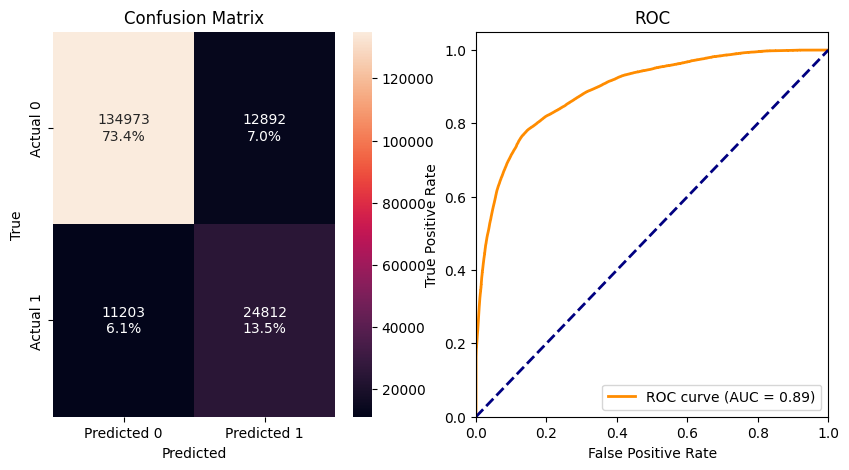

In [143]:
weights, config = torch.load('../best_model-lstm.pth')
# config = json.load(open('../logs/search256/34/config.json'))
# weights = torch.load('../logs/search256/34/best_model.pth')
model = LSTMNet(config).to(device)
model.load_state_dict(weights)
evaluate(model, valloader, trainloader)

In [ ]:
# full session